# 4. Pre-Processing and Training Data

## Imports

In [1]:
#Import required modules
import os
import shutil
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import matplotlib.dates as mdates

from pathlib import Path

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import ppscore as pps

from pycaret.regression import *

#!pip install xlsxwriter
import xlsxwriter

## Modeling Settings

### n-month ahead prediction

In [2]:
# Define n-month ahead prediction (1-6)
N_MONTH = 6
print(N_MONTH)

6


### Directories

In [3]:
#### Root derectory ####

# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)
print(ROOT_DIR)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01


In [4]:
#### File directory ####

#Define file name and location
file_csv = 'step3_eda_wti_price.csv'
file_path = '\\data\\interim\\'

#Set file name and location
f = ROOT_DIR + file_path + file_csv
print(f)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\step3_eda_wti_price.csv


In [5]:
#### Model directory ####
# Change direcotry to the '\models' folder
# Generate the name
model_name = 'regression_model_' + str(N_MONTH) + 'm'
model_path =  ROOT_DIR + '\\models\\' + model_name


#verwrite folder if exisits
if os.path.exists(model_path):
    shutil.rmtree(model_path)

#Make folder
try: 
    os.mkdir(model_path)
except OSError as error: 
    print(error)

os.chdir(model_path)
os.getcwd()

'D:\\gitProjects\\springboard_capstone_1\\Springboard_Capstone_01\\models\\prediction_model_6m'

### Targe feature 

In [6]:
#Set target feature
TARGET_FEATURE = 'wti_price'

## Read Data

In [7]:
#cast csv to dataframe
df = pd.read_csv(f)

#convert 'Date' column to date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df.set_index('Date', drop=True, inplace=True)

#print shape of dataframe
print('Shape:',df.shape)

#display df head
display(df.head(7).round(2).T)

Shape: (269, 30)


Date,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01
wti_price,29.37,29.84,25.72,28.79,31.82,29.70,31.26
oil_production_opec,26.68,26.61,27.52,28.05,27.64,27.91,28.88
oil_production_nonopec,46.82,46.94,46.62,46.62,46.78,47.05,46.93
oil_production_world,74470.54,74439.05,75116.13,75639.56,75360.22,75983.05,76857.51
henry_hub_ng_price,2.66,2.79,3.04,3.59,4.29,3.99,4.43
oil_production_us,5.85,5.92,5.85,5.85,5.82,5.74,5.79
petrol_consumption_oecd,50.23,49.36,46.29,47.34,47.96,47.25,49.83
petrol_consumption_nonoecd,28.77,28.53,28.13,28.22,28.27,28.54,28.70
us_cpi,1.70,1.71,1.71,1.71,1.72,1.73,1.73
us_ppi,1.30,1.31,1.31,1.32,1.32,1.33,1.34


## Pre-process

#### Custom functions

In [8]:
def get_var_name(variable):
    '''This function gets a variable and prints its name'''
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [9]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

In [10]:
def count_over_thershold(li, bounding_limit: tuple):
    '''This function gets a list and print how many items are larger than a thersold'''
    
    #counters
    n = len(li)
    m = 0    
    for i in li:
        if i >= bounding_limit[1] or i < bounding_limit[0] :
            m +=1
    pct = 100.0*m/n
    print(f'{pct:1.2f}% of items ({m}/{n}) are out of {bounding_limit}')   

In [11]:
def highlight_out_of_range(data, bounding_limit: tuple, title, y_label):
    '''This functions gets PPS score for target feature and plot a bar plot'''
    lower_bound = bounding_limit[0]
    upper_bound = bounding_limit[1]
    
    #Plot the scores for a select feature from PPS Matrix
    data= data.sort_values(ascending = False)

    #The value > thershold will be show with a different color.
    #So, the plot colors will be dynamically set based on the data

    #Create and empty list of colors
    colors = []

    #Set color for ratio values
    #Set "red" if value is max, otherwise "blue" (as default)
    for index, value in data.items():
        if value >= upper_bound or value <= lower_bound:
            colors.append('#f77088') #red for max
        else:
            colors.append('#66aabb') #blue as default

    #set chart size
    fig = plt.figure(figsize = (15, 2))

    #Pass the x and height values with color set to bar plotter
    plt.bar(data.index,data.values, width = .8, color=colors)

    #Rotate the x labels for better visuzlaizarion
    plt.xticks(rotation=90)

    #Set labels
    plt.ylabel(y_label)
    plt.title(title)    
    
    count_over_thershold(data, bounding_limit)

    plt.savefig(y_label +'.png', dpi=300, bbox_inches = 'tight')
    
    #Show the plot
    plt.show()


In [12]:
def target_corr_coeff(df, feature):
    
    # Compute the correlation matrix
    corr = df.corr()
    y_scores = corr[feature]
    
    y_scores.drop(TARGET_FEATURE, inplace = True)
    
    return y_scores

In [13]:
def target_pps_score(df, feature):
    # Compute the PPS matrix
    matrix = pps.matrix(df)
    matrix_pps = matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    y_scores = matrix_pps[feature]
    
    y_scores.drop(TARGET_FEATURE, inplace = True)
    
    return y_scores

### Generate n-month future price data 

In [14]:
#Make a copy of dataframe
df_new = df.copy()

#Shift by n-month
df_new['wti_price'] = df_new['wti_price'].shift(-N_MONTH)

#print tail of 1,2,3,6-month future dataframes
display(df_new.tail(13), '\n')

,wti_price,oil_production_opec,oil_production_nonopec,oil_production_world,henry_hub_ng_price,oil_production_us,petrol_consumption_oecd,petrol_consumption_nonoecd,us_cpi,us_ppi,...,global_econ_policy_uncert_index,comp,copper_futures,djia,dxy,gold_futures,spx,wti_brent_price_spread,wti_crack_spread,brent_crack_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,71.71,26.015000,64.107520,93226.180018,3.26,11.356417,45.684016,52.728647,2.70955,2.278168,...,176.148901,14097.169091,4.2890,34289.907273,92.44,1772.4,4238.489545,-1.78,450.9600,445.6200
2021-07-01,83.22,26.720000,64.889591,94729.111965,3.84,11.346986,45.659315,52.526239,2.72184,2.304027,...,203.423906,14639.072857,4.4655,34798.804286,92.17,1814.5,4363.712857,-2.68,468.1300,460.0900
2021-08-01,91.64,26.705000,64.374205,94237.576423,4.07,11.277405,45.817553,52.005166,2.73092,2.334078,...,213.007581,14856.517727,4.3700,35243.965455,92.63,1816.9,4454.206364,-3.02,471.8100,462.7500
2021-09-01,108.50,27.105000,64.144036,94517.465618,5.16,10.917534,46.142698,53.084795,2.74214,2.363054,...,202.797704,15023.538571,4.0890,34688.421429,94.23,1757.0,4445.543333,-2.84,471.0500,462.5300
2021-10-01,101.78,27.375000,65.232828,95800.268436,5.51,11.568579,46.224255,52.704461,2.76590,2.385176,...,193.205196,14879.012381,4.3590,35055.518095,94.12,1784.9,4460.707143,-2.06,504.7600,498.5800
2021-11-01,109.55,27.755000,65.549871,96443.732530,5.05,11.790052,46.754084,53.584987,2.78524,2.416337,...,225.540047,15814.932857,4.2805,35848.570952,95.99,1776.5,4667.386667,-1.90,504.7500,499.0500
2021-12-01,114.84,27.870000,64.942184,95875.830991,3.76,11.634403,47.680515,54.625111,2.80126,2.450757,...,263.150452,15474.431818,4.4635,35641.334091,95.97,1829.7,4674.772727,-2.46,472.9700,465.5900
2022-01-01,NaN,27.820000,64.703430,95847.261127,4.38,11.369338,44.651171,52.928249,2.81933,2.479540,...,232.732585,14531.377500,4.3265,35456.145000,96.54,1796.4,4573.815500,-3.29,489.9400,480.0700
2022-02-01,NaN,28.575000,64.906274,96799.257236,4.69,11.316119,46.757972,53.968755,2.84182,2.527154,...,189.550345,13898.728421,4.4545,34648.480526,96.71,1902.2,4435.980526,-5.49,535.8800,519.4100


'\n'

### Handle Missing Values

#### Print missing values

In [15]:
count_missing(df_new)

,count,%
wti_price,6,2.230483


#### Impute missing values

In [16]:
dropped_row = df_new.dropna(axis = 0, inplace = False)
print('Before:', df_new.shape)
print('After:', dropped_row.shape)

Before: (269, 30)
After: (263, 30)


### Final Dataset

In [17]:
df = dropped_row.copy()

## EDA n-month future

### Score assosciation with target feature

#### High PPS Score

0.00% of items (0/29) are out of (0, 0.6)


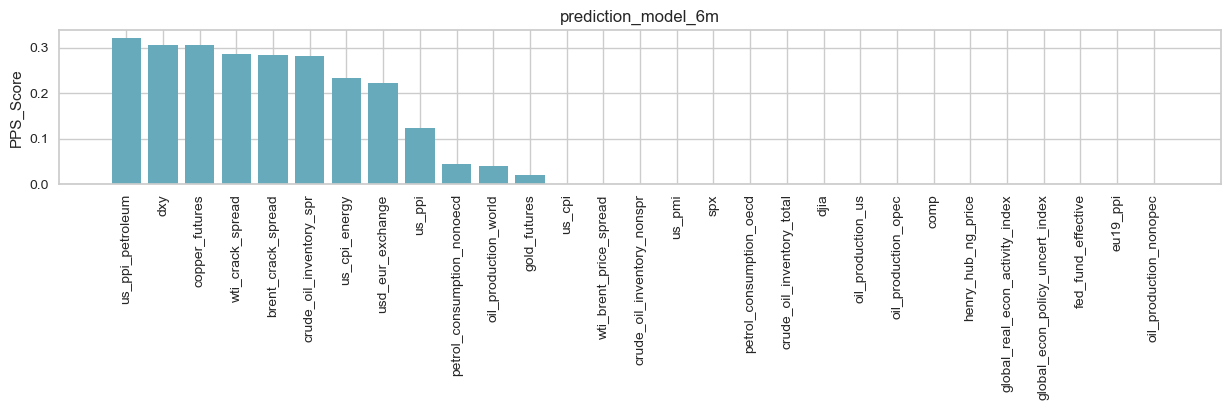

In [18]:
wti_pps_score = target_pps_score(df, TARGET_FEATURE)
highlight_out_of_range(wti_pps_score, (0,0.6), model_name, 'PPS_Score')

#### High Correlation Coeff

27.59% of items (8/29) are out of (-0.6, 0.6)


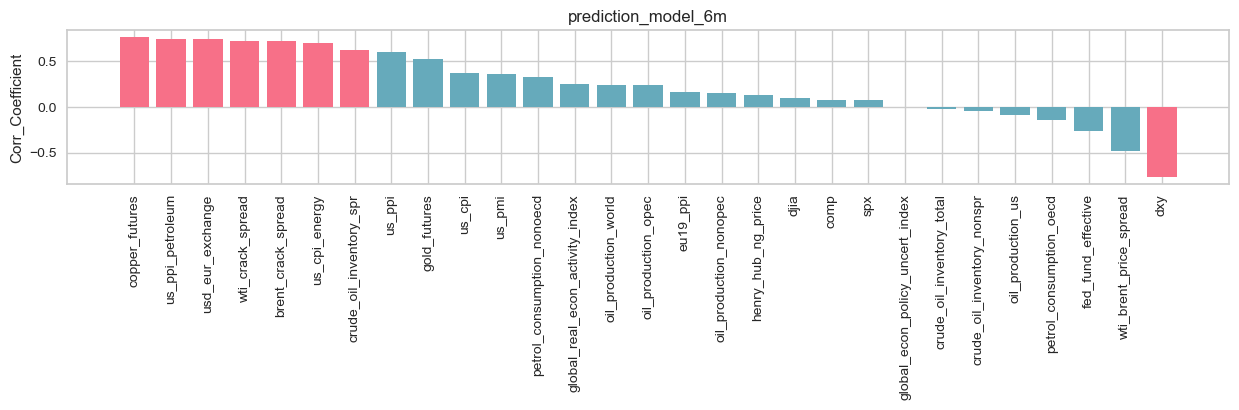

In [19]:
wti_corr_coeff = target_corr_coeff(df, TARGET_FEATURE)
highlight_out_of_range(wti_corr_coeff, (-0.6,0.6), model_name, 'Corr_Coefficient')

## Train/Test Split

In [20]:
#expected 70-30 split sizes
print(round(len(df) * 0.7, 0))
print(round(len(df) * 0.3, 0))

184.0
79.0


In [21]:
#split data to 70$ train and 30% test sets
#... = train_test_split(X, y, test_size, random_state)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=TARGET_FEATURE),
                                                    df[TARGET_FEATURE], test_size=0.3,
                                                    random_state=47)

In [22]:
print('(X_train, X_test):\n',X_train.shape, X_test.shape)
print('\n(y_train, y_test):\n',y_train.shape, y_test.shape)

(X_train, X_test):
 (184, 29) (79, 29)

(y_train, y_test):
 (184,) (79,)


### Imputing missing feature (predictor) values
Impute missing values using scikit-learn. Learn values to impute from a train split and apply that to the test split.

In [23]:
display(count_missing(X_train))

,count,%


In [24]:
display(count_missing(X_test))

,count,%


In [25]:
#No missing data
X_tr = X_train.copy()
X_te = X_test.copy()

### Scale Data

In [26]:
def scale_train_test_dataframes(X_tr, X_te):
    '''This function gets a dataframe and normalized columns and return a new data frame'''
    
    #store column names
    names = X_tr.columns
    
    from sklearn.preprocessing import StandardScaler

    #Call the StandardScaler`s fit method on `X_tr` to fit the scaler
    #then use it's `transform()` method to apply the scaling to both the train and test split
    #data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively

    scaler = StandardScaler()
    
    #scale data using sklearn preprocessing module
    scaler.fit(X_tr)
    
    X_tr_scaled = scaler.transform(X_tr)
    
    X_te_scaled = scaler.transform(X_te)

    #create new df using scaled data
    X_tr_scaled_df = pd.DataFrame(X_tr_scaled, columns=names)
    X_te_scaled_df = pd.DataFrame(X_te_scaled, columns=names)

    #set index
    X_tr_scaled_df.set_index(X_tr.index, drop=True, inplace=True)
    X_te_scaled_df.set_index(X_te.index, drop=True, inplace=True)

    #return scaled dataframe
    return X_tr_scaled_df, X_te_scaled_df

In [27]:
X_tr_scaled, X_te_scaled_df = scale_train_test_dataframes(X_tr, X_te)

#### Plot scaled data

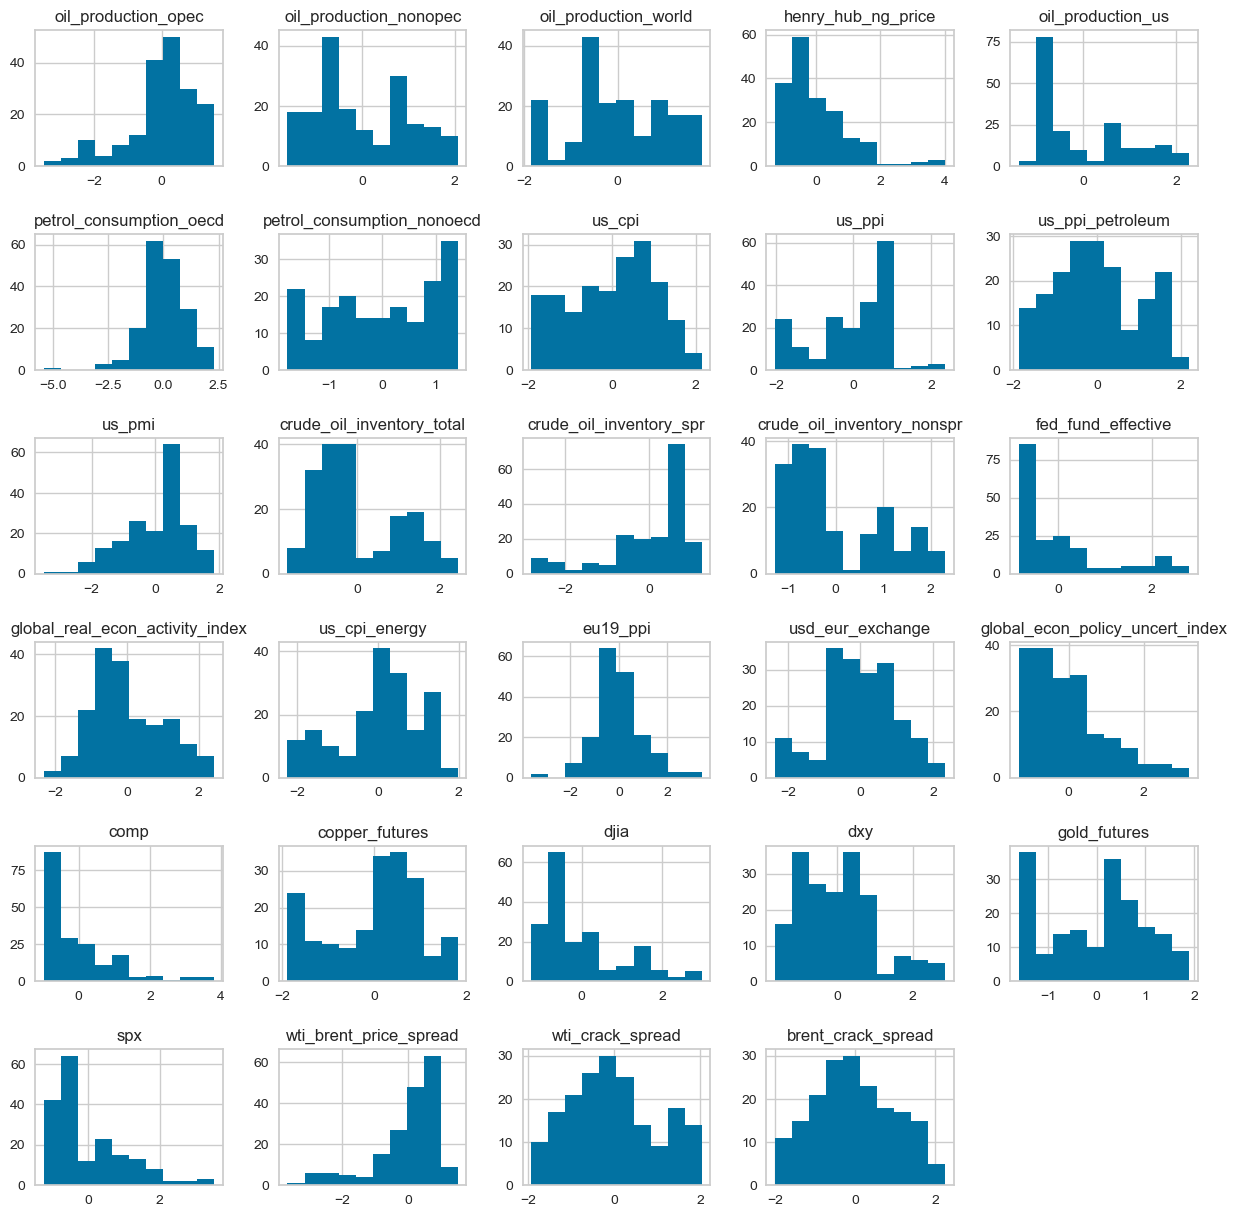

In [28]:
#Plot histogram of all  features
#Call plt.subplots_adjust() with an argument hspace=0.5 to adjust the spacing
#It's important you create legible and easy-to-read plots
X_tr_scaled.hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);

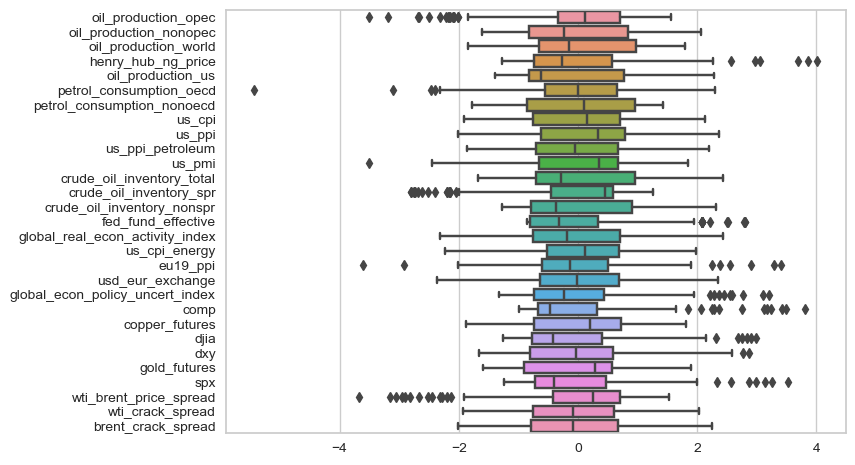

In [29]:
sns.boxplot(data = X_tr_scaled, orient = 'h')
plt.show()

## Conduct Regression Model in PyCaret

### Setup the session

In [30]:
#Setup Pycaret Regression session
#Transform dataset, normalize and split the dataset.
#Log experiments and plots for experiments to be viewed later with MLflow. 

reg_model = setup(data=df, 
                target=TARGET_FEATURE,
                session_id=786,
                transformation=True,
                normalize=True,
                train_size=0.7,
                log_plots=True)

,Description,Value
0,Session id,786
1,Target,wti_price
2,Target type,Regression
3,Data shape,"(263, 30)"
4,Train data shape,"(184, 30)"
5,Test data shape,"(79, 30)"
6,Numeric features,29
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


### Compare models

In [31]:
# Use compare_models() function to compare ML models and their perfomrance on the data
# Use the default fold value from 10 to 5 for cross-validation generator

# Store the top 5 models in top5.
# We plan to use this for Stacking and Blending purposes. 

top5 = compare_models(n_select=5, sort='RMSE', fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5.5594,73.7049,8.4816,0.8710,0.1482,0.1047,0.0720
gbr,Gradient Boosting Regressor,6.2188,85.0515,9.0861,0.8512,0.1595,0.1169,0.0460
rf,Random Forest Regressor,6.8388,107.3570,10.3030,0.8225,0.1691,0.1230,0.0940
ada,AdaBoost Regressor,7.3003,109.0278,10.3647,0.8207,0.1799,0.1400,0.0420
lightgbm,Light Gradient Boosting Machine,7.4772,114.2278,10.6544,0.8144,0.1781,0.1354,0.0280
lr,Linear Regression,8.5157,130.0237,11.3696,0.7905,0.2629,0.1672,1.0460
ridge,Ridge Regression,8.2410,131.1705,11.3924,0.7906,0.1984,0.1540,0.0200
knn,K Neighbors Regressor,7.6885,133.8207,11.4489,0.7820,0.1823,0.1381,0.0220
br,Bayesian Ridge,8.4057,139.8110,11.7601,0.7774,0.1973,0.1563,0.0180
huber,Huber Regressor,8.8013,140.1657,11.7863,0.7762,0.2119,0.1666,0.0260


In [32]:
# Case the result to a dataframe
compare_model_table = pull()

### Hyper-parameterization

Tune the top 5 models dynamically with a higher iteration rate (n_iter).

This is to find more optimal hyper parameters over a larger search space. 

In [33]:
#create an empty list with 5 elements
tuned_top5 = [None] * 5

#counter
i = 0 

#interate over the top5 and store the tuned models
for top in top5:
    #tune the model
    tuned_top5[i] = tune_model(top, n_iter=120, optimize='RMSE', fold=5) 
    
    # Save the dataframe to CSV
    tuned_name  = 'pycaret_tune_model_' + str(i+1)
    globals()[tuned_name] = pull()
    
    i += 1

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.1056,78.4689,8.8583,0.8357,0.1755,0.1367
1,4.9324,54.4523,7.3792,0.9256,0.1855,0.1174
2,5.5836,83.1186,9.1169,0.8801,0.1493,0.1027
3,5.7475,85.3925,9.2408,0.9123,0.1054,0.0775
4,6.9968,95.6608,9.7806,0.7809,0.1542,0.1186
Mean,5.8732,79.4186,8.8752,0.8669,0.1540,0.1106
Std,0.6784,13.6924,0.8063,0.0530,0.0277,0.0197


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.2789,94.4214,9.7171,0.8023,0.1751,0.1460
1,4.6643,56.6118,7.5241,0.9226,0.1871,0.1149
2,6.6634,91.0981,9.5445,0.8686,0.1648,0.1166
3,6.1337,84.0510,9.1679,0.9137,0.1055,0.0862
4,6.1212,55.1993,7.4296,0.8736,0.1235,0.1045
Mean,6.1723,76.2763,8.6766,0.8762,0.1512,0.1136
Std,0.8653,16.9724,0.9960,0.0426,0.0313,0.0195


Fitting 5 folds for each of 120 candidates, totalling 600 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.0998,75.8850,8.7112,0.8411,0.1731,0.1353
1,4.9683,65.0217,8.0636,0.9112,0.1885,0.1152
2,5.8361,79.9611,8.9421,0.8846,0.1483,0.1027
3,5.9966,104.7583,10.2351,0.8924,0.1138,0.0807
4,6.7234,83.2282,9.1230,0.8094,0.1457,0.1132
Mean,5.9249,81.7709,9.0150,0.8677,0.1539,0.1094
Std,0.5650,13.0307,0.7076,0.0371,0.0256,0.0178


Fitting 5 folds for each of 120 candidates, totalling 600 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.8368,112.3344,10.5988,0.7648,0.2036,0.1724
1,6.5654,82.7413,9.0962,0.8869,0.2036,0.1452
2,7.8151,155.5432,12.4717,0.7756,0.1882,0.1362
3,6.7610,97.2309,9.8606,0.9002,0.1376,0.1090
4,6.8645,81.4693,9.0260,0.8134,0.1563,0.1208
Mean,7.1686,105.8638,10.2107,0.8282,0.1779,0.1367
Std,0.5453,27.2550,1.2673,0.0559,0.0265,0.0218


Fitting 5 folds for each of 120 candidates, totalling 600 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.9690,121.3178,11.0144,0.7460,0.1972,0.1632
1,6.1359,76.9709,8.7733,0.8948,0.1795,0.1247
2,6.7605,91.9299,9.5880,0.8674,0.1439,0.1102
3,6.3878,95.0123,9.7474,0.9024,0.1192,0.0937
4,6.5250,73.3607,8.5651,0.8320,0.1432,0.1077
Mean,6.7556,91.7183,9.5377,0.8485,0.1566,0.1199
Std,0.6395,16.9795,0.8669,0.0569,0.0280,0.0238


Fitting 5 folds for each of 120 candidates, totalling 600 fits


### Combine top 5 models

#### Build blend models

In [34]:
# Building a blending model from our top 5 models and evaluate the results. 
# Blending models is an ensemble method of combining different machine learning algorithms.
# Use a majority vote to build consensus of final prediction values.

blender_specific = blend_models(estimator_list=tuned_top5[0:], fold=5, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.7156,82.2935,9.0716,0.8277,0.1749,0.1435
1,4.8881,56.9211,7.5446,0.9222,0.1833,0.1141
2,6.1759,86.4175,9.2961,0.8753,0.1485,0.1065
3,5.7356,80.4716,8.9706,0.9174,0.1052,0.0825
4,6.3457,69.8126,8.3554,0.8401,0.1371,0.1073
Mean,5.9722,75.1833,8.6477,0.8765,0.1498,0.1108
Std,0.6269,10.6497,0.6335,0.0386,0.0280,0.0196


In [35]:
# Case the result to a dataframe
pycaret_blend_model = pull()

In [36]:
# Below is a view of the model parameters. 
print(blender_specific)
display(blender_specific)

VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=786)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.15,
                                                       max_features='log2',
                                                       min_impurity_decrease=0.0005,
                                                       min_samples_leaf=4,
                                                       min_samples_split=7,
                                                       n_estimators=130,
                                                       random_state=786,
                                                       subsample=0.95)),
                            ('Random Forest Regressor',
                             RandomForest...
                            ('AdaBoost Regressor',
                             AdaBoostRegressor(l

VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=786)),
                            ('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.15,
                                                       max_features='log2',
                                                       min_impurity_decrease=0.0005,
                                                       min_samples_leaf=4,
                                                       min_samples_split=7,
                                                       n_estimators=130,
                                                       random_state=786,
                                                       subsample=0.95)),
                            ('Random Forest Regressor',
                             RandomForest...
                            ('AdaBoost Regressor',
                             AdaBoostRegressor(learning_rate=0.3, loss='square',
                                               n_estimators=190,
                                               random_state=786)),
                            ('Light Gradient Boosting Machine',
                             LGBMRegressor(bagging_fraction=1.0, bagging_freq=5,
                                           feature_fraction=0.6,
                                           learning_rate=0.15,
                                           min_child_samples=16,
                                           min_split_gain=0.8, n_estimators=300,
                                           num_leaves=50, random_state=786,
                                           reg_alpha=1e-06, reg_lambda=0.1))],
                n_jobs=-1)

#### Build stack models

In [37]:
# Build a stacking model from our top 5 models and evaluate the results.
# Stacking models is an ensemble method of using meta learning.
# A meta model is created using multiple base estimators to generate the final prediction.

stacker_specific = stack_models(estimator_list=tuned_top5[1:],
                                meta_model=tuned_top5[0],
                                fold=5,
                                optimize='RMSE',
                                choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.9766,71.2015,8.4381,0.8509,0.1545,0.1210
1,4.5362,50.8850,7.1334,0.9305,0.1821,0.1112
2,5.6099,66.2767,8.1411,0.9044,0.1325,0.0963
3,5.8474,88.6869,9.4174,0.9089,0.1071,0.0811
4,5.8577,61.8551,7.8648,0.8583,0.1374,0.0979
Mean,5.5656,67.7811,8.1989,0.8906,0.1427,0.1015
Std,0.5282,12.4227,0.7473,0.0308,0.0249,0.0136


In [38]:
# Case the result to a dataframe
pycaret_stack_model = pull()

In [39]:
# Below is a view of the model parameters. 
print(stacker_specific)
display(stacker_specific)

StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting Regressor',
                               GradientBoostingRegressor(learning_rate=0.15,
                                                         max_features='log2',
                                                         min_impurity_decrease=0.0005,
                                                         min_samples_leaf=4,
                                                         min_samples_split=7,
                                                         n_estimators=130,
                                                         random_state=786,
                                                         subsample=0.95)),
                              ('Random Forest Regressor',
                               RandomForestRegressor(bootstrap=False,
                                                     criterion='mae',
                                                     max_depth=9,
                            

StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting Regressor',
                               GradientBoostingRegressor(learning_rate=0.15,
                                                         max_features='log2',
                                                         min_impurity_decrease=0.0005,
                                                         min_samples_leaf=4,
                                                         min_samples_split=7,
                                                         n_estimators=130,
                                                         random_state=786,
                                                         subsample=0.95)),
                              ('Random Forest Regressor',
                               RandomForestRegressor(bootstrap=False,
                                                     criterion='mae',
                                                     max_depth=9,
                                                     max_feature...
                                                 random_state=786)),
                              ('Light Gradient Boosting Machine',
                               LGBMRegressor(bagging_fraction=1.0,
                                             bagging_freq=5,
                                             feature_fraction=0.6,
                                             learning_rate=0.15,
                                             min_child_samples=16,
                                             min_split_gain=0.8,
                                             n_estimators=300, num_leaves=50,
                                             random_state=786, reg_alpha=1e-06,
                                             reg_lambda=0.1))],
                  final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                      random_state=786),
                  n_jobs=-1, passthrough=True)

### Evaluare models

#### Evaluate blend model

In [40]:
evaluate_model(blender_specific)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate stack model

In [41]:
evaluate_model(stacker_specific)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate the perforomances

cooks: blend vs stack


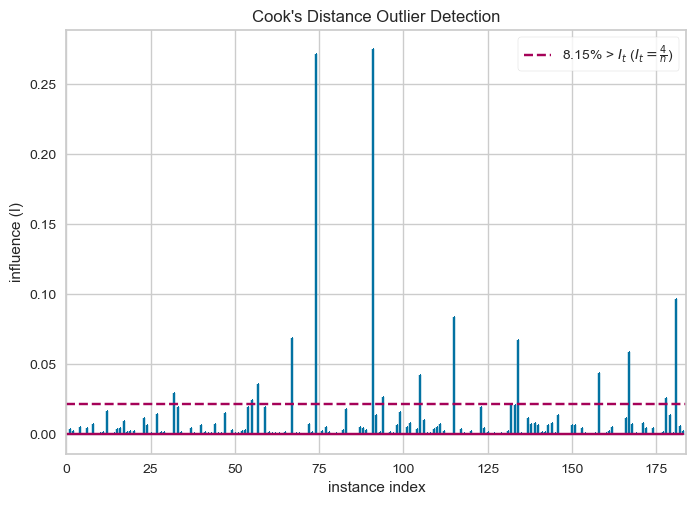

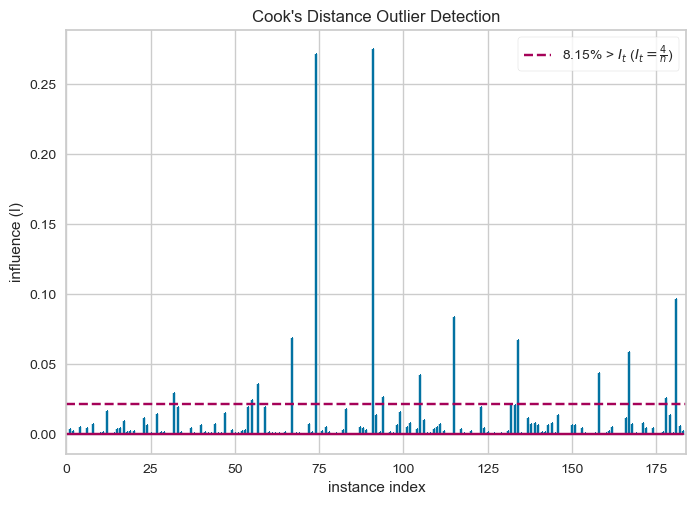

manifold: blend vs stack


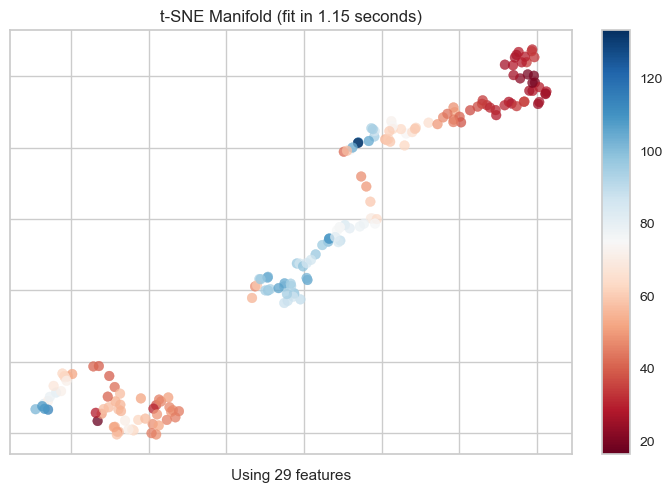

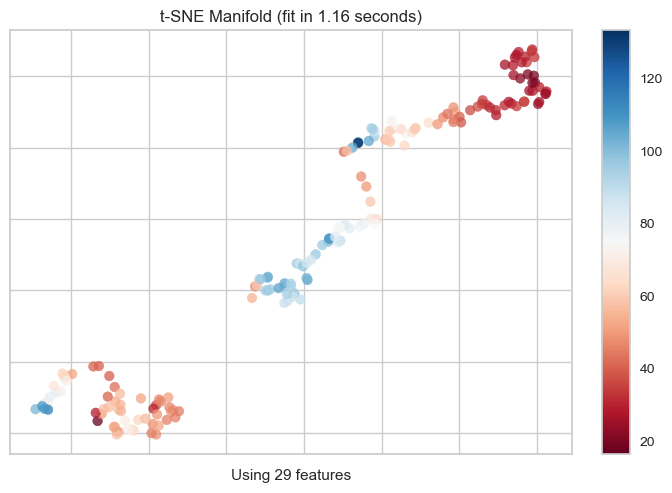

In [42]:
print('cooks: blend vs stack')
plot_model(blender_specific, plot='cooks', verbose=True, scale=1)
plot_model(stacker_specific, plot='cooks', verbose=True, scale=1)

print('manifold: blend vs stack')
plot_model(blender_specific, plot='manifold', verbose=True, scale=1)
plot_model(stacker_specific, plot='manifold', verbose=True, scale=1)

residuals: blend vs stack


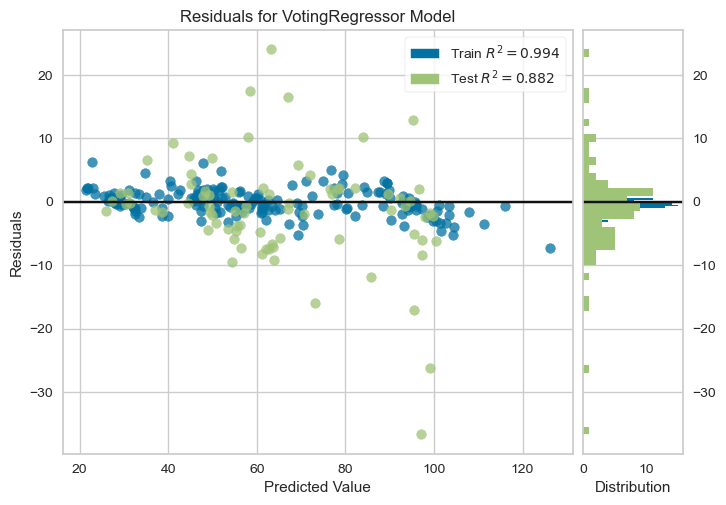

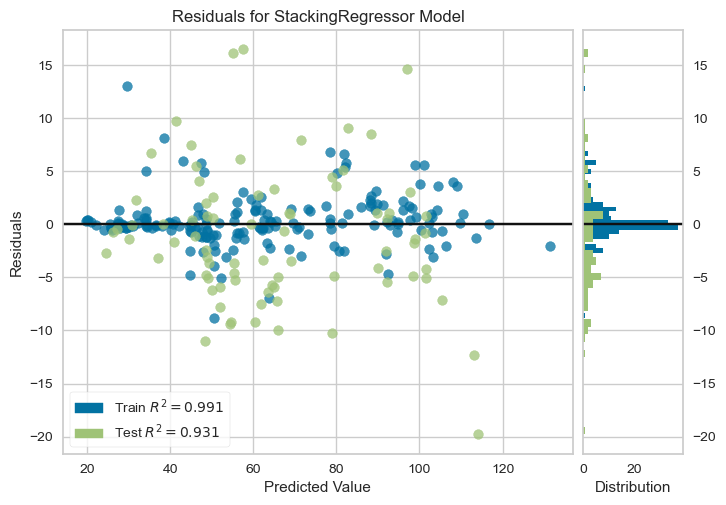

error: blend vs stack


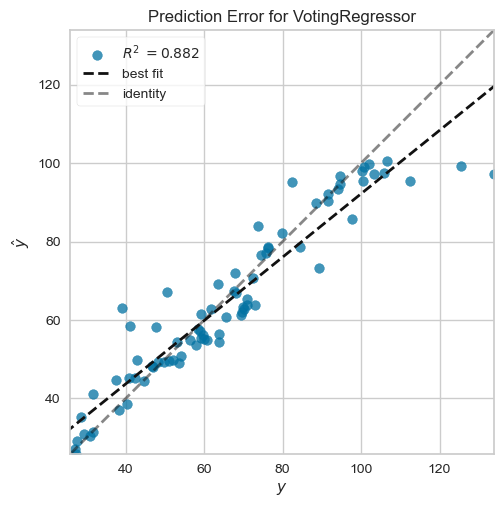

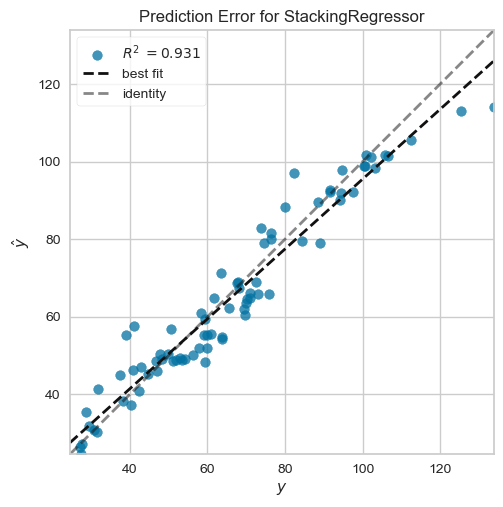

learning: blend vs stack


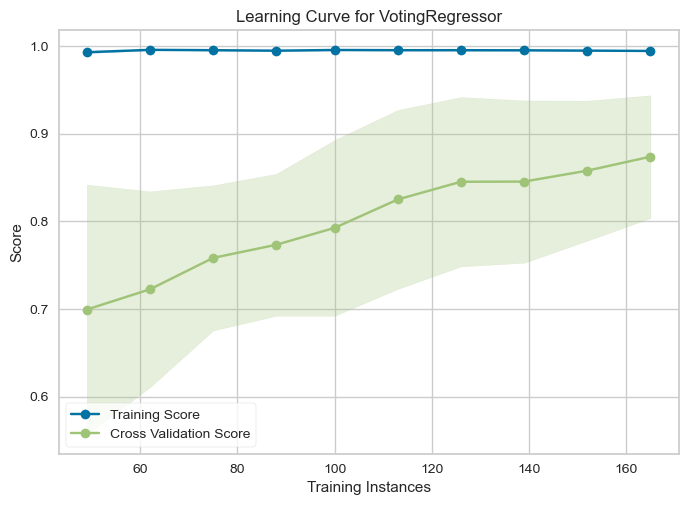

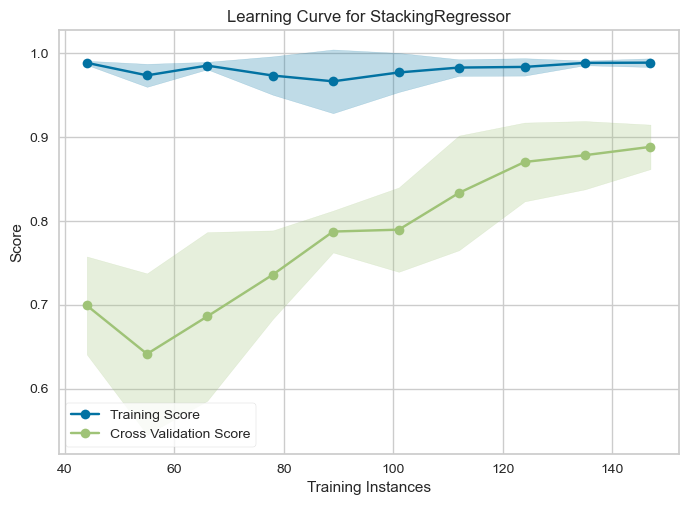

In [43]:
# Use Pycaret's built in plot_model() function to generate side-by-side plots:
# Dispaly Residuals chart, Prediction Error and Cross Validation (learning) charts.
print('residuals: blend vs stack')
plot_model(blender_specific, plot='residuals', scale=1)
plot_model(stacker_specific, plot='residuals', scale=1)

print('error: blend vs stack')
plot_model(blender_specific, plot='error', scale=1)
plot_model(stacker_specific, plot='error', scale=1)

print('learning: blend vs stack')
plot_model(blender_specific, plot='learning', scale=1)
plot_model(stacker_specific, plot='learning', scale=1)

In [44]:
# Execute the predict_model() function to use the blender model to generate the predicted values. 
pred_tunded_blender = predict_model(blender_specific)
pycaret_pred_blend = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,5.4631,70.1657,8.3765,0.8818,0.1193,0.0859


In [45]:
# Execute the predict_model() function to use the stack model to generate the predicted values. 
pred_tunded_stacker = predict_model(stacker_specific, verbose = True)
pycaret_pred_stack = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,4.9497,41.0405,6.4063,0.9309,0.1040,0.0816


#### Set the final model

In [46]:
# The stack model seems to perform better in both our train and test so let us finalize it.
#The finalize_model() function trains the model on the entire dataset. 

finalized_model = finalize_model(stacker_specific)
display(finalized_model)

Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['oil_production_opec',
                                             'oil_production_nonopec',
                                             'oil_production_world',
                                             'henry_hub_ng_price',
                                             'oil_production_us',
                                             'petrol_consumption_oecd',
                                             'petrol_consumption_nonoecd',
                                             'us_cpi', 'us_ppi',
                                             'us_ppi_petroleum', 'us_pmi',
                                             'crude_o...
                                                                  random_state=786)),
                                               ('Light Gradient Boosting '
                                                'Machine',
                                                LGBMRegressor(bagging_fraction=1.0,
                                                              bagging_freq=5,
                                                              feature_fraction=0.6,
                                                              learning_rate=0.15,
                                                              min_child_samples=16,
                                                              min_split_gain=0.8,
                                                              n_estimators=300,
                                                              num_leaves=50,
                                                              random_state=786,
                                                              reg_alpha=1e-06,
                                                              reg_lambda=0.1))],
                                   final_estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                       random_state=786),
                                   n_jobs=-1, passthrough=True))])

In [47]:
pred_finalized_model = predict_model(finalized_model, verbose = True)
pycaret_pred_finalized = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,3.0283,17.3493,4.1652,0.9708,0.0744,0.0544


## Save the final model

In [48]:
print(model_path)

D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\models\prediction_model_6m


In [49]:
# Save pipeline
save_model(finalized_model, model_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\Farid\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['oil_production_opec',
                                              'oil_production_nonopec',
                                              'oil_production_world',
                                              'henry_hub_ng_price',
                                              'oil_production_us',
                                              'petrol_consumption_oecd',
                                              'petrol_consumption_nonoecd',
                                              'us_cpi', 'us_ppi',
                                              'us_ppi_petroleum', 'us_pmi',
                                              'crude_o...
                                                                   random_state=786)),
                                                ('Light Gradient Boosting '
                           

## Save Pycaret tables to Excel

In [50]:
with pd.ExcelWriter(model_path + '\\pycaret_tables.xlsx', engine='xlsxwriter') as writer:
  # Write each dataframe to one ksheet.
    compare_model_table.to_excel(writer, sheet_name='compare_models')
    pycaret_tune_model_1.to_excel(writer, sheet_name='tuned_1')
    pycaret_tune_model_2.to_excel(writer, sheet_name='tuned_2')
    pycaret_tune_model_3.to_excel(writer, sheet_name='tuned_3')
    pycaret_tune_model_4.to_excel(writer, sheet_name='tuned_4')
    pycaret_tune_model_5.to_excel(writer, sheet_name='tuned_5')
    pycaret_blend_model.to_excel(writer, sheet_name='blend_model') 
    pycaret_stack_model.to_excel(writer, sheet_name='stack_model')
    pycaret_pred_blend.to_excel(writer, sheet_name='pred_blend')
    pycaret_pred_stack.to_excel(writer, sheet_name='pred_stack')
    pycaret_pred_finalized.to_excel(writer, sheet_name='pred_final')